# Social Graphs Project: Analyzing artists and songs

In [1]:
import re
import requests
import json
import networkx as nx
from tqdm import tqdm
import json
import codecs
from requests.exceptions import ReadTimeout
import lyricsgenius
import csv
import numpy as np

# Data collection

To start with, we want a list of artists (we chose the Wikipedia list of hip-hop artist).
Once we have it, we will, for every artist, find the list of all their songs, and all of the other artists they featured on a song.

#### From Wikipedia

#### From Spotify

In [2]:
# Loading the final data set

# Format:
# data = {artist: [wikipedia_link, spotify_uri, [featured_artist, ...], [song_name, ...]], ...}

with codecs.open("C:/Users/difto/Desktop/Cours/02805 Social graphs and interactions/Project/Source/socialgraph-final-project/Data/data_final.txt", 'r', "utf-8") as f:
    data = json.load(f)

#### From Genius

Now we get the lyrics from a few songs of every artist, in order to later try to identify patterns.

In [3]:
def processLyrics(text):
    text = text.lower()
    # Removing all the [Chorus], [Verse 1], etc
    for a in re.findall(r'\[[\w\s:]+\]', text):
        text = text.replace(a, ' ')
    # Removing all the line breaks
    for a in re.findall(r'\n', text):
        text = text.replace(a, ' ')
    # Removing all the punctuations
    for a in re.findall(r"['\s]|(\W)", text):
        text = text.replace(a, '')
    # Removing context words/meta data
    for a in re.findall(r"translation[s]*|español|italiano|português|türkçe|deutsch|azərbaycanca|français|lyrics|[\d]*embed|türkçes|русский|हनद|venska|آذربايجان", text):
        text = text.replace(a, '')
    return text

In [4]:
# Sometimes the Lyricsgenius package gives us a list of songs ("Artist - Song") instead of lyrics
# We spot this error by counting the number of dash in the text ("-")

# Some other time, the package doesn't find the actual song and returns something completely differen
# We spot this error by checking the title
def isResponseValid(artist, song_title, response_song_title, response_lyrics): 
    a = [c for c in response_song_title.lower() if c.isalnum()]
    b = [c for c in song_title.lower() + " by " + artist.lower() if c.isalnum()]
    condition1 = a[:len(b)] == b
    if not condition1:
        return False
    condition2 = (len(re.findall(r'-', response_lyrics))+len(re.findall(r'—', response_lyrics)))/len(response_lyrics)<0.01
    return condition1 and condition2

In [5]:
artists_degrees = []
with open('Data/artists_degrees.csv', newline='') as csvfile:
    line = csv.reader(csvfile)
    i = 0
    for row in line:
        if i == 0:
            i += 1
            pass
        else:
            artists_degrees.append((int(row[5]), row[1]))
artists_degrees = sorted(artists_degrees, reverse=True)

In [81]:
artists_degrees

[(617, 'snoop dogg'),
 (489, 'lil wayne'),
 (473, 'gucci mane'),
 (438, 'e-40'),
 (418, '2 chainz'),
 (412, 'rick ross'),
 (406, 'busta rhymes'),
 (402, 'wiz khalifa'),
 (373, 'future'),
 (344, 'mos def'),
 (343, 'lil baby'),
 (343, 'chris brown'),
 (333, 't.i.'),
 (330, 'pharrell williams'),
 (328, 'young thug'),
 (327, 'the game'),
 (318, 'french montana'),
 (318, 'big sean'),
 (313, 'juicy j'),
 (311, 'wale'),
 (310, 'jadakiss'),
 (305, 'roddy ricch'),
 (305, 'don toliver'),
 (304, 'nas'),
 (303, 'nate dogg'),
 (301, 'warren g'),
 (300, 'lil durk'),
 (299, 'yg'),
 (298, 'post malone'),
 (298, 'playboi carti'),
 (297, 'rah digga'),
 (296, 'big daddy kane'),
 (295, 'ludacris'),
 (293, 'slick rick'),
 (286, 'black rob'),
 (285, 'inspectah deck'),
 (285, 'gunna'),
 (284, 'meek mill'),
 (284, "lil' kim"),
 (282, 'gza'),
 (282, 'fabolous'),
 (276, 'lil uzi vert'),
 (276, 'bun b'),
 (275, 'missy elliott'),
 (272, 'the notorious b.i.g.'),
 (272, 't-pain'),
 (268, 'offset'),
 (267, 'raekwon'

In [ ]:
# Getting the lyrics of a given song from Genius

#GENIUS_CLIENT_ID = "gCDSyLMANvERLDi4GdVvKN6l7-QB1y2NHSkPr6QCUPVjKzEG_93CxN6Plj82nzWh"
GENIUS_ACCESS_TOKEN = "eAW6zYgc_Mf2dYp3xkouP8c8SuGjWg76mlVC95htgmJtOkD_OpKbwXK8aqfQMFRA"

genius = lyricsgenius.Genius(GENIUS_ACCESS_TOKEN)
genius.verbose = False
genius.skip_non_songs = True

lyrics = {}

MIN_LYRICS_LENGTH = 20000 # Approximately 5 songs

save = 0
failed = []

for artist in tqdm([x for (_, x) in artists_degrees]):
    try:
        if len(data[artist])>2:
            text = ""
            songs_used = []
            songs_nb = len(data[artist][3])
                
            while len(text) < MIN_LYRICS_LENGTH:
                
                # Make sure we have songs left to try
                if len(songs_used) >= songs_nb:
                    break
                
                # Selecting a random song among all the artist's songs
                song_number = np.random.randint(0, songs_nb)
                while song_number in songs_used:
                    song_number = np.random.randint(0, songs_nb)
                songs_used.append(song_number)
                
                # Getting the song's lyrics
                song = data[artist][3][song_number]
                try:
                    response = genius.search_song(song, artist)
                    # Checking that we got the right song
                    if isResponseValid(artist, song, response.full_title, response.lyrics):
                        # Processing the lyrics to remove unwanted notation and words
                        text += processLyrics(response.lyrics)
                except:
                    pass
                
            lyrics[artist] = text.split()
            save += 1
            
        # We make a save for every 50 artists    
        if save > 50:
            with codecs.open("C:/Users/difto/Desktop/Cours/02805 Social graphs and interactions/Project/Source/socialgraph-final-project/Data/lyrics"+str(save//50)+".txt", 'w', "utf-8") as f:
                f.write(json.dumps(lyrics))
            save = 0
            
    except:
        failed.append(artist)

 19%|█▊        | 515/2780 [4:58:55<08:43,  4.32it/s]     

In [79]:
GENIUS_ACCESS_TOKEN = "eAW6zYgc_Mf2dYp3xkouP8c8SuGjWg76mlVC95htgmJtOkD_OpKbwXK8aqfQMFRA"

genius = lyricsgenius.Genius(GENIUS_ACCESS_TOKEN)
genius.verbose = False
genius.skip_non_songs = True

response = genius.search_song("white america", "eminem")
# Checking that we got the right song
if isResponseValid("eminem", "white america", response.full_title, response.lyrics):
# Processing the lyrics to remove unwanted notation and words
    print(processLyrics(response.lyrics))

white america   america ha ha ha we love you how many people are proud to be citizens of this beautiful country of ours the stripes and the stars for the rights that men have died for to protect the women and men who have broke their necks for the freedom of speech the united states government has sworn to uphold or so we're told yo i want everybody to listen to the words of this song    i never would've dreamed in a million years i'd see so many motherfuckin' people who feel like me who share the same views and the same exact beliefs it's like a fuckin' army marchin' in back of me so many lives i touched so much anger aimed in no particular direction just sprays and sprays and straight through your radio waves it plays and plays 'til it stays stuck in your head for days and days who would've thought standin' in this mirror bleachin' my hair with some peroxide reachin' for a tshirt to wear that i would catapult to the forefront of rap like this how could i predict my words would have a

In [67]:
text = "translationstürkçesvenskaespañolportuguêsenglishहनदdeutschfrançaisazərbaycanca  آذربايجانрусскийlose yourself lyrics  look if you had one shot or one opportunity to seize everything you ever wanted in one moment would you capture it or just let it slip yo   his palms are sweaty knees weak arms are heavy there's vomit on his sweater already mom's spaghetti he's nervous but on the surface he looks calm and ready to drop bombs but he keeps on forgetting what he wrote down the whole crowd goes so loud he opens his mouth but the words won't come out he's choking how everybody's joking now the clock's run out time's up over blaow snap back to reality ope there goes gravity ope there goes rabbit he choked he's so mad but he won't give up that easy no he won't have it he knows his whole back's to these ropes it don't matter he's dope he knows that but he's broke he's so stagnant he knows when he goes back to this mobile home that's when it's back to the lab again yo this old rhapsody better go capture this moment and hope it don't pass him and   you better lose yourself in the music the moment you own it you better never let it go go you only get one shot do not miss your chance t"
# Removing context words/meta data
for a in re.findall(r"translation[s]*|español|português|deutsch|azərbaycanca|français|lyrics|15kembed|türkçes|русский|हनद|venska|آذربايجان", text):
    text = text.replace(a, '')
    print(a)

print(text)

translations
türkçes
venska
español
português
हनद
deutsch
français
azərbaycanca
آذربايجان
русский
lyrics
english  lose yourself   look if you had one shot or one opportunity to seize everything you ever wanted in one moment would you capture it or just let it slip yo   his palms are sweaty knees weak arms are heavy there's vomit on his sweater already mom's spaghetti he's nervous but on the surface he looks calm and ready to drop bombs but he keeps on forgetting what he wrote down the whole crowd goes so loud he opens his mouth but the words won't come out he's choking how everybody's joking now the clock's run out time's up over blaow snap back to reality ope there goes gravity ope there goes rabbit he choked he's so mad but he won't give up that easy no he won't have it he knows his whole back's to these ropes it don't matter he's dope he knows that but he's broke he's so stagnant he knows when he goes back to this mobile home that's when it's back to the lab again yo this old rhapso

### Ideas for NLP based on lyrics

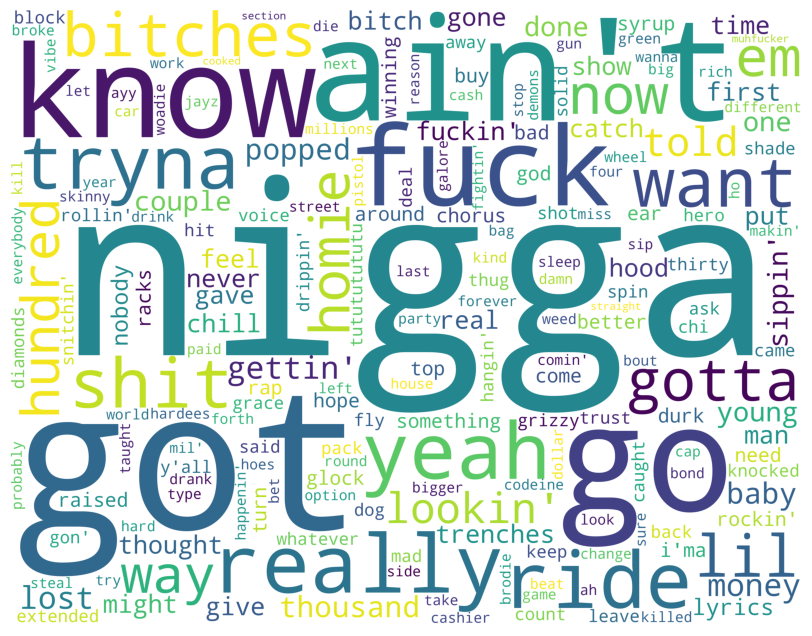

In [18]:
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Removing the stop words from the lyrics
text = [w for w in lyrics['lil baby'] if w not in STOPWORDS]

# Creating the frequency distribution
#fdist = nltk.FreqDist(text)

# Getting the most common words in the distribution
#fdist.most_common()

dc_wordcloud = WordCloud(collocations=False,
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=3600,
                      height=2800
                     ).generate(" ".join(text))

plt.figure(figsize=(15, 8))
plt.imshow(dc_wordcloud)
plt.axis('off')
plt.show()

# Creating the graph

Now we can create the graph, following these rules:

1. Every node corresponds to one artist
1. An edge exists between two nodes if and only if the two corresponding artists are featured on a song (made by one of the two artists, i.e. for now we don't handle the case where, say, 3 artists are on a same song)

In [42]:
# Creating the graph without node attributes for now

G = nx.Graph()

for artist in data:
    G.add_node(artist)
    if len(data[artist]) > 2:
        for featured_artist in data[artist][2]:
            if featured_artist in data:
                G.add_edge(artist, featured_artist)

angie martinez
